In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [3]:
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

--2023-03-13 06:45:04--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  44.6MB/s    in 2m 55s  

2023-03-13 06:47:59 (43.5 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2023-03-13 06:48:00--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  45.4MB/s    in 44s     

2023-03-13 06:48:45 (44.4 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2023-03-13 06:48:45--  https:

# Data Preparation

In [74]:
BATCH_SIZE = 128

def get_bird_data(augmentation=0):

    # Define transformations for train and test set
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 224x224 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Generate train, val, and test datasets
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)

    # 90:10 split of training set to generate a validation set
    train_split, val_split = random_split(trainset, [int(0.9 * len(trainset) + 1), int( 0.1 * len(trainset))])

    trainloader = torch.utils.data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
print(len(data['train'].dataset))
print(len(data['val'].dataset))
print(len(data['test'].dataset))

34706
3856
10000


torch.Size([4, 3, 224, 224])


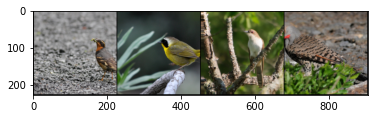

In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:4]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

# Helper Methods

In [5]:
def train(net, dataloader, val_loader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    train_losses = []
    val_losses = []

    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        train_losses = state['train_losses']
        val_losses = state['val_losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        net.train()
        train_loss = 0.0
        train_acc = 0.0
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            train_loss += loss.item()
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
              
        train_losses.append(train_loss / len(dataloader))

        # Validation loop; use .no_grad() context manager to save memory.
        if val_loader is not None:
          net.eval()
          val_loss = 0.0

          with torch.no_grad():
            for batch in val_loader:
              inputs, labels = batch[0].to(device), batch[1].to(device)
              ouputs = net(inputs)
              loss = criterion(ouputs, labels)

              val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))

        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'train_losses': train_losses, 'val_losses': val_losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

    return train_losses, val_losses

In [6]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# Transfer Learning on Bird Dataset

This section contains several different tests on pretrained models. The models that are testing include the following:

1. Resnet18
2. Resnet50
3. Resnet50 with no validation all training and more data augmentation
4. Try to use larger images after pretraining on smaller images

## Resnet18 

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

checkpoints = '/content/drive/MyDrive/colab_files/birds/resnet18'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
losses, val_losses = train(resnet, data['train'], data['val'], epochs=5, schedule={0:0.1, 2:0.01}, print_every=10, checkpoint_path=checkpoints)

Learning rate: 0.100000
[0,    10] loss: 6.443
[0,    20] loss: 6.263
[0,    30] loss: 5.729
[0,    40] loss: 5.515
[0,    50] loss: 5.065
[0,    60] loss: 4.845
[0,    70] loss: 4.621
[0,    80] loss: 4.550
[0,    90] loss: 4.463
[0,   100] loss: 4.330
[0,   110] loss: 4.150
[0,   120] loss: 3.997
[0,   130] loss: 3.933
[0,   140] loss: 3.879
[0,   150] loss: 3.872
[0,   160] loss: 3.722
[0,   170] loss: 3.664
[0,   180] loss: 3.498
[0,   190] loss: 3.379
[0,   200] loss: 3.332
[0,   210] loss: 3.249
[0,   220] loss: 3.113
[0,   230] loss: 3.272
[0,   240] loss: 3.166
[0,   250] loss: 3.192
[0,   260] loss: 3.123
[0,   270] loss: 3.104
[1,    10] loss: 2.999
[1,    20] loss: 2.821
[1,    30] loss: 2.754
[1,    40] loss: 2.854
[1,    50] loss: 2.803
[1,    60] loss: 2.704
[1,    70] loss: 2.736
[1,    80] loss: 2.729
[1,    90] loss: 2.679
[1,   100] loss: 2.727
[1,   110] loss: 2.675
[1,   120] loss: 2.588
[1,   130] loss: 2.639
[1,   140] loss: 2.492
[1,   150] loss: 2.614
[1,   160]

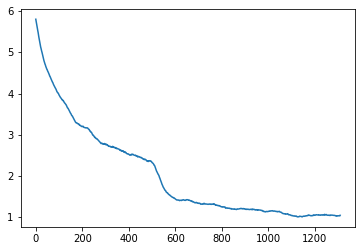

In [ ]:
plt.plot(smooth(losses,50))

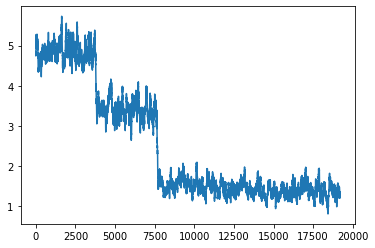

In [ ]:
plt.plot(smooth(val_losses,75))

In [ ]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/resnet18/'
state = torch.load(checkpoints + 'checkpoint-4.pkl')
losses, val_losses = train(resnet, data['train'], data['val'], start_epoch=5, epochs=8, schedule={4:0.01, 6: 0.001}, print_every=10, state=state, checkpoint_path=checkpoints)

Learning rate: 0.010000
[4,    10] loss: 1.009
[4,    20] loss: 1.111
[4,    30] loss: 1.079
[4,    40] loss: 1.044
[4,    50] loss: 1.073
[4,    60] loss: 1.041
[4,    70] loss: 1.048
[4,    80] loss: 1.040
[4,    90] loss: 1.061
[4,   100] loss: 0.981
[4,   110] loss: 1.048
[4,   120] loss: 1.148
[4,   130] loss: 1.050
[4,   140] loss: 1.037
[4,   150] loss: 1.015
[4,   160] loss: 1.063
[4,   170] loss: 1.060
[4,   180] loss: 1.045
[4,   190] loss: 1.005
[4,   200] loss: 1.020
[4,   210] loss: 1.014
[4,   220] loss: 1.052
[4,   230] loss: 1.036
[4,   240] loss: 1.142
[4,   250] loss: 1.065
[4,   260] loss: 0.988
[4,   270] loss: 1.024
[5,    10] loss: 0.952
[5,    20] loss: 0.929
[5,    30] loss: 0.923
[5,    40] loss: 0.954
[5,    50] loss: 0.885
[5,    60] loss: 0.926
[5,    70] loss: 0.943
[5,    80] loss: 0.914
[5,    90] loss: 1.036
[5,   100] loss: 0.937
[5,   110] loss: 0.958
[5,   120] loss: 0.943
[5,   130] loss: 0.978
[5,   140] loss: 0.879
[5,   150] loss: 0.981
[5,   160]

In [ ]:
predict(resnet, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## Resnet50

In [ ]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 555) # This will reinitialize the layer as well

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/resnet50/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
losses, val_losses = train(resnet50, data['train'], data['val'], start_epoch=5, epochs=6, lr=0.01, print_every=10, checkpoint_path=checkpoints)

[5,    10] loss: 0.914
[5,    20] loss: 0.905
[5,    30] loss: 0.838
[5,    40] loss: 0.832
[5,    50] loss: 0.940
[5,    60] loss: 0.858
[5,    70] loss: 0.864
[5,    80] loss: 0.916
[5,    90] loss: 0.919
[5,   100] loss: 0.902
[5,   110] loss: 0.832
[5,   120] loss: 0.926
[5,   130] loss: 0.913
[5,   140] loss: 0.897
[5,   150] loss: 0.968
[5,   160] loss: 0.895
[5,   170] loss: 0.921
[5,   180] loss: 0.893
[5,   190] loss: 0.892
[5,   200] loss: 0.909
[5,   210] loss: 0.862
[5,   220] loss: 0.876
[5,   230] loss: 0.847
[5,   240] loss: 0.894
[5,   250] loss: 0.926
[5,   260] loss: 0.895
[5,   270] loss: 0.928


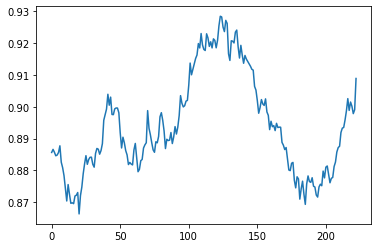

In [ ]:
plt.plot(smooth(losses,50))

In [ ]:
state = torch.load(checkpoints + 'checkpoint-6.pkl')
losses, val_losses = train(resnet50, data['train'], data['val'], start_epoch=6, epochs=9, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

[6,    10] loss: 0.784
[6,    20] loss: 0.766
[6,    30] loss: 0.848
[6,    40] loss: 0.839
[6,    50] loss: 0.857
[6,    60] loss: 0.786
[6,    70] loss: 0.843
[6,    80] loss: 0.841
[6,    90] loss: 0.806
[6,   100] loss: 0.849
[6,   110] loss: 0.878
[6,   120] loss: 0.844
[6,   130] loss: 0.797
[6,   140] loss: 0.760
[6,   150] loss: 0.817
[6,   160] loss: 0.879
[6,   170] loss: 0.795
[6,   180] loss: 0.835
[6,   190] loss: 0.819
[6,   200] loss: 0.790
[6,   210] loss: 0.813
[6,   220] loss: 0.804
[6,   230] loss: 0.759
[6,   240] loss: 0.838
[6,   250] loss: 0.786
[6,   260] loss: 0.825
[6,   270] loss: 0.803
[7,    10] loss: 0.786
[7,    20] loss: 0.728
[7,    30] loss: 0.716
[7,    40] loss: 0.743
[7,    50] loss: 0.735
[7,    60] loss: 0.794
[7,    70] loss: 0.779
[7,    80] loss: 0.774
[7,    90] loss: 0.786
[7,   100] loss: 0.716
[7,   110] loss: 0.746
[7,   120] loss: 0.780
[7,   130] loss: 0.737
[7,   140] loss: 0.715
[7,   150] loss: 0.755
[7,   160] loss: 0.763
[7,   170] 

In [ ]:
predict(resnet50, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## Resnet (experiment 2) Transfer Learning

This time we will use a Resnet model with no validation dataset and also affine 

In [ ]:
# Define transformations for train and test set
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 224x224 crops from padded images
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    transforms.RandomPerspective(0.25, 0.25),
    transforms.ToTensor(),
])

# Generate train, val, and test datasets
trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
resnet50_v2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
num_ftrs = resnet50_v2.fc.in_features
resnet50_v2.fc = nn.Linear(num_ftrs, 555) # This will reinitialize the layer as well

In [ ]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/resnet50_v2/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
losses, val_losses = train(resnet50_v2, trainloader, None, epochs=5, schedule={0:0.1, 3:0.01}, print_every=10, checkpoint_path=checkpoints)

In [ ]:
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses, val_losses = train(resnet50_v2, trainloader, None, start_epoch=5, epochs=7, lr=0.01, print_every=10, state=state, checkpoint_path=checkpoints)

In [ ]:
state = torch.load(checkpoints + 'checkpoint-7.pkl')
losses, val_losses = train(resnet50_v2, trainloader, None, start_epoch=7, epochs=11, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

In [ ]:
plt.plot(smooth(losses,50))

In [ ]:
state = torch.load(checkpoints + 'checkpoint-11.pkl')
resnet50_v2.load_state_dict(state['net'])
predict(resnet50, data['test'], checkpoints + "preds.csv")

## Let's try using larger images now maybe that will help

This used up too many resources. Not efficient.

In [ ]:
# Define transformations for train and test set
transform_train = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomCrop(512, padding=8, padding_mode='edge'), # Take 224x224 crops from padded images
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    transforms.ToTensor(),
])

# Generate train, val, and test datasets
trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)

trainloader_large = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
state = torch.load(checkpoints + 'checkpoint-11.pkl')
losses, val_losses = train(resnet50_v2, trainloader_large, None, start_epoch=11, epochs=13, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

## EfficientNet_b0

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=555))
model.to(device)

In [ ]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/Resnet50/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
train_losses, val_losses = train(model, data['train'], data['val'], epochs=5, schedule={0:0.1, 2: 0.01}, print_every=10, checkpoint_path=checkpoints)

[0,    10] loss: 2.494
[0,    20] loss: 2.090


KeyboardInterrupt: ignored

## Resnet50 with v2 weights
 
Accuracy: .7995

In [69]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 555)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/Resnet50/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
train_losses, val_losses = train(model, data['train'], data['val'], epochs=5, schedule={0:0.1, 2: 0.01}, print_every=10, checkpoint_path=checkpoints)

Learning rate: 0.100000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f92aa08ce50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


OutOfMemoryError: ignored

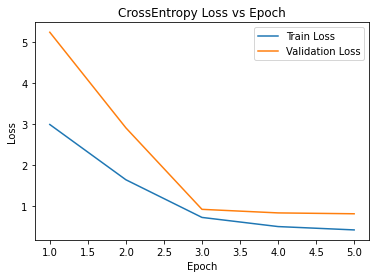

In [ ]:
epochs = range(1, 6)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CrossEntropy Loss vs Epoch")
plt.show()

In [ ]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/Resnet50/'
state = torch.load(checkpoints + 'checkpoint-7.pkl')
print(state['epoch'])

7


In [ ]:
train_losses, val_losses = train(model, data['train'], data['val'], epochs=10, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

[7,    10] loss: 0.267
[7,    20] loss: 0.280
[7,    30] loss: 0.283
[7,    40] loss: 0.316
[7,    50] loss: 0.292
[7,    60] loss: 0.298
[7,    70] loss: 0.275
[7,    80] loss: 0.311
[7,    90] loss: 0.290
[7,   100] loss: 0.299
[7,   110] loss: 0.281
[7,   120] loss: 0.315
[7,   130] loss: 0.299
[7,   140] loss: 0.278
[7,   150] loss: 0.297
[7,   160] loss: 0.292
[7,   170] loss: 0.293
[7,   180] loss: 0.285
[7,   190] loss: 0.294
[7,   200] loss: 0.270
[7,   210] loss: 0.302
[7,   220] loss: 0.320
[7,   230] loss: 0.291
[7,   240] loss: 0.300
[7,   250] loss: 0.333
[7,   260] loss: 0.289
[7,   270] loss: 0.287
[8,    10] loss: 0.231
[8,    20] loss: 0.244
[8,    30] loss: 0.260
[8,    40] loss: 0.224
[8,    50] loss: 0.276
[8,    60] loss: 0.274
[8,    70] loss: 0.212
[8,    80] loss: 0.271
[8,    90] loss: 0.237
[8,   100] loss: 0.236
[8,   110] loss: 0.242
[8,   120] loss: 0.252
[8,   130] loss: 0.253
[8,   140] loss: 0.268
[8,   150] loss: 0.271
[8,   160] loss: 0.262
[8,   170] 

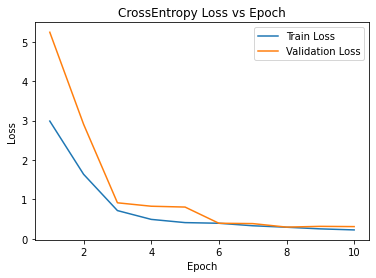

In [ ]:
epochs = range(1, 11)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CrossEntropy Loss vs Epoch")
plt.show()

In [ ]:
predict(model, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [76]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/Resnet50/'
state = torch.load(checkpoints + 'checkpoint-13.pkl')
print(state['train_losses'])
print(state['val_losses'])

[2.988625919994186, 1.6375558893470203, 0.716428503722829, 0.4927413358407862, 0.4109168100882979, 0.39446640420047674, 0.330974789117189, 0.29359552850398946, 0.2519773317172247, 0.2254188564222525, 0.20898970613694368, 0.17996076554717386, 0.1571514970239471]
[5.2447486295080035, 2.9068508296282802, 0.9140272367201736, 0.8268557038303399, 0.8057318879123264, 0.39456819982093627, 0.3859594821677635, 0.2965309173431549, 0.31585906516155987, 0.3094830174473708, 0.21061728469329466, 0.2672227604349301, 0.23673370631061075]


In [77]:
train_losses, val_losses = train(model, data['train'], data['val'], epochs=14, lr=0.0001, print_every=10, state=state, checkpoint_path=checkpoints)

[13,    10] loss: 0.125
[13,    20] loss: 0.118
[13,    30] loss: 0.130
[13,    40] loss: 0.129
[13,    50] loss: 0.136
[13,    60] loss: 0.114
[13,    70] loss: 0.150
[13,    80] loss: 0.136
[13,    90] loss: 0.130
[13,   100] loss: 0.139
[13,   110] loss: 0.164
[13,   120] loss: 0.150
[13,   130] loss: 0.141
[13,   140] loss: 0.135
[13,   150] loss: 0.148
[13,   160] loss: 0.134
[13,   170] loss: 0.161
[13,   180] loss: 0.133
[13,   190] loss: 0.169
[13,   200] loss: 0.132
[13,   210] loss: 0.159
[13,   220] loss: 0.147
[13,   230] loss: 0.162
[13,   240] loss: 0.162
[13,   250] loss: 0.143
[13,   260] loss: 0.152
[13,   270] loss: 0.156


In [78]:
predict(model, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [79]:
print(val_losses)

[5.2447486295080035, 2.9068508296282802, 0.9140272367201736, 0.8268557038303399, 0.8057318879123264, 0.39456819982093627, 0.3859594821677635, 0.2965309173431549, 0.31585906516155987, 0.3094830174473708, 0.21061728469329466, 0.2672227604349301, 0.23673370631061075, 0.2479043942796815]


## EfficientNet

In [60]:
model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Linear(num_ftrs, 555)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [58]:
gc.collect()
torch.cuda.empty_cache()

In [61]:
checkpoints = '/content/drive/MyDrive/colab_files/birds/EfficientNet/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
train_losses, val_losses = train(model, data['train'], data['val'], epochs=5, schedule={0:0.1, 2: 0.01}, print_every=10, checkpoint_path=checkpoints)

Learning rate: 0.100000
[0,    10] loss: 6.251
[0,    20] loss: 5.944
[0,    30] loss: 5.554
[0,    40] loss: 5.516
[0,    50] loss: 5.369
[0,    60] loss: 5.261
[0,    70] loss: 5.110
[0,    80] loss: 4.930
[0,    90] loss: 4.892
[0,   100] loss: 4.665
[0,   110] loss: 4.576
[0,   120] loss: 4.540
[0,   130] loss: 4.490
[0,   140] loss: 4.487
[0,   150] loss: 4.238
[0,   160] loss: 4.176
[0,   170] loss: 4.135
[0,   180] loss: 3.941
[0,   190] loss: 3.954
[0,   200] loss: 3.995
[0,   210] loss: 3.823
[0,   220] loss: 3.888
[0,   230] loss: 3.824
[0,   240] loss: 3.765
[0,   250] loss: 3.629
[0,   260] loss: 3.583
[0,   270] loss: 3.534
[0,   280] loss: 3.543
[0,   290] loss: 3.251
[0,   300] loss: 3.309
[0,   310] loss: 3.428
[0,   320] loss: 3.301
[0,   330] loss: 3.274
[0,   340] loss: 3.255
[0,   350] loss: 3.282
[0,   360] loss: 3.311
[0,   370] loss: 3.136
[0,   380] loss: 3.205
[0,   390] loss: 3.261
[0,   400] loss: 3.131
[0,   410] loss: 3.017
[0,   420] loss: 2.991
[0,   430]

In [62]:
state = torch.load(checkpoints + 'checkpoint-5.pkl')
print(state['epoch'])

5


In [63]:
train_losses, val_losses = train(model, data['train'], data['val'], epochs=10, lr=0.001, print_every=10, state=state, checkpoint_path=checkpoints)

[5,    10] loss: 0.625
[5,    20] loss: 0.636
[5,    30] loss: 0.584
[5,    40] loss: 0.676
[5,    50] loss: 0.610
[5,    60] loss: 0.643
[5,    70] loss: 0.616
[5,    80] loss: 0.594
[5,    90] loss: 0.655
[5,   100] loss: 0.593
[5,   110] loss: 0.673
[5,   120] loss: 0.660
[5,   130] loss: 0.601
[5,   140] loss: 0.654
[5,   150] loss: 0.644
[5,   160] loss: 0.575
[5,   170] loss: 0.687
[5,   180] loss: 0.711
[5,   190] loss: 0.625
[5,   200] loss: 0.564
[5,   210] loss: 0.711
[5,   220] loss: 0.663
[5,   230] loss: 0.635
[5,   240] loss: 0.711
[5,   250] loss: 0.744
[5,   260] loss: 0.698
[5,   270] loss: 0.664
[5,   280] loss: 0.627
[5,   290] loss: 0.615
[5,   300] loss: 0.649
[5,   310] loss: 0.654
[5,   320] loss: 0.728
[5,   330] loss: 0.719
[5,   340] loss: 0.722
[5,   350] loss: 0.727
[5,   360] loss: 0.661
[5,   370] loss: 0.670
[5,   380] loss: 0.657
[5,   390] loss: 0.627
[5,   400] loss: 0.674
[5,   410] loss: 0.556
[5,   420] loss: 0.590
[5,   430] loss: 0.702
[5,   440] 

In [64]:
print(train_losses)

[3.7846116009777204, 2.2912635168757007, 1.179815260635116, 0.86723507230014, 0.7354046673296126, 0.6506264851347957, 0.5796684876331308, 0.5250873504751954, 0.4784406052549021, 0.452018068969579]


In [65]:
print(val_losses)

[2.905156659742708, 2.4199750984443504, 1.1521775672467718, 1.0653295708039627, 0.9873102972689115, 0.940639273161211, 0.8942570020727163, 0.9214688264638045, 0.9132831874661128, 0.8960600497791208]


In [66]:
predict(model, data['test'], checkpoints + "preds.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
